In [434]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [435]:
lst = [1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
len(lst)

65

In [436]:
score_for_pass = 65

In [437]:
events_data = pd.read_csv(r'C:\Users\79922\Desktop\event_data_train.csv')
submissions_data = pd.read_csv(r'C:\Users\79922\Desktop\submissions_data_train.csv')

In [438]:
submissions_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [439]:
def delete_current_users(events_data, submissions_data):
    """Удалим пользователей, которые на момент выгрузки данных ещё проходят курс.
        Для этого изучим длительность обучения пользователей, получивших сертификат.
        Возьмем 95-99 персентиль в качестве "порога длительности обучения".
        Если пользователь без сертификата учится дольше, чем порог - считаем что он бросил курс."""
    # Узнаем время правильного решения 65-й задачи. Это и будет время окончания курса.
    # Для этого соберем датафрейм из первых 65-ти событий успешного решения практического шага:
    tmp = submissions_data.query('submission_status == "correct"').sort_values(['user_id', 'timestamp']).groupby(
        'user_id').head(score_for_pass)

    #максимальная разница во времени - время получения сертификата
    obtainin_cert = tmp.groupby('user_id').timestamp.max().to_frame().rename(columns={'timestamp': 'obtaining_cert'})

    # создаем таблицу с первым и последним действием юзера
    min_max_user_time = events_data.groupby('user_id').agg({'timestamp': 'min'}).rename(
        columns={'timestamp': 'min_timestamp'}).reset_index()

    data = pd.merge(obtainin_cert, min_max_user_time, on='user_id')
    data['days_spent_on_obtaining_cert'] = np.ceil(
        (data['obtaining_cert'] - data['min_timestamp']) / (24 * 60 * 60)).map(
        int)
    data.days_spent_on_obtaining_cert.hist()

    #return np.percentile(data.days_spent_on_obtaining_cert, 95)
    return data.days_spent_on_obtaining_cert.describe(percentiles=[.9, .95, .99])


In [440]:
def real_delete(events_data, users_data, cut_off_days=333):
    users_time_feature = events_data.groupby('user_id').agg({'timestamp': ['min', 'max']}).droplevel(
        level=0, axis=1).reset_index()
    users_time_feature['current'] = (now - users_time_feature['min']) / (60 * 60 * 24)
    #return users_time_feature
    #return users_data
    a = pd.merge(users_time_feature, users_data[users_data['passed_course'] == 0], on='user_id', how='inner')
    b = pd.merge(a[['user_id', 'passed_course']], users_data[users_data['passed_course'] == 1], on='user_id',
                 how='outer')
    return pd.concat([a[['user_id', 'passed_course']], users_data[users_data['passed_course'] == 1]])
    return a[['user_id', 'passed_course']].append(users_data[users_data['passed_course'] == 1])
    return a[a['current'] > cut_off_days]['user_id']
    #return pd.merge(users_time_feature, users_data[users_data['passed_course'] == 0], on='user_id', how='inner')['current'] > cut_off_days
    #return users_data[users_data['passed_course'] == 0]

#real_delete(events_data, target(submissions_data=submissions_data, events_data=events_data))

count    9794.000000
mean       56.186951
std       135.364025
min         1.000000
50%         7.000000
90%       162.700000
95%       333.000000
99%       724.070000
max      1063.000000
Name: days_spent_on_obtaining_cert, dtype: float64

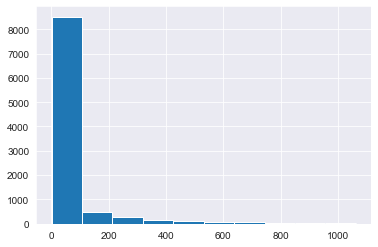

In [441]:
delete_current_users(events_data, submissions_data)

In [442]:
events_data_test = pd.read_csv('data/events_data_test.csv')
submissions_data_test = pd.read_csv('data/submission_data_test.csv')

In [443]:
now = events_data_test.timestamp.max()

In [444]:
#now = events_data.timestamp.max()
#now

In [445]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [446]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [447]:
def time_filter(data, days=2):
    """Фильтруем данные за первые сколько-то дней"""

    # создаем таблицу с первым и последним действием юзера
    min_max_user_time = data.groupby('user_id').agg({'timestamp': 'min'}).rename(
        columns={'timestamp': 'min_timestamp'}).reset_index()

    data_time_filtered = pd.merge(data, min_max_user_time, on='user_id', how='outer')

    # отбираем те записи, которые не позднее какого-то количества дней с начала учебы
    learning_time_threshold = days * 24 * 60 * 60
    data_time_filtered = data_time_filtered.query("timestamp <= min_timestamp + @learning_time_threshold")

    assert data_time_filtered.user_id.nunique() == data.user_id.nunique()

    return data_time_filtered.drop(['min_timestamp'], axis=1)


time_filter(submissions_data).head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
7,31977,1434347371,correct,15853


In [448]:
def base_features(events_data, submissions_data):
    """Создаем датасет с базовыми фичами: действия пользователя
    и правильные\неправильные ответы"""

    # таблица с действиями каждого пользователя
    users_events_data = pd.pivot_table(data=events_data, values='step_id',
                                       index='user_id', columns='action',
                                       aggfunc='count', fill_value=0).reset_index().rename_axis('', axis=1)

    # количество правильных и неправильных попыток
    users_scores = pd.pivot_table(data=submissions_data,
                                  values='step_id',
                                  index='user_id',
                                  columns='submission_status',
                                  aggfunc='count',
                                  fill_value=0).reset_index().rename_axis('', axis=1)

    """Создание фичи с долей правильных ответов"""

    users_data = pd.merge(users_scores, users_events_data, on='user_id', how='outer').fillna(0)
    #добавим долю правильных ответов
    users_data['correct_ratio'] = (users_data.correct / (users_data.correct + users_data.wrong)).fillna(0)

    assert users_data.user_id.nunique() == events_data.user_id.nunique()

    return users_data


base_features(events_data, submissions_data).head()

,user_id,correct,wrong,discovered,passed,started_attempt,viewed,correct_ratio
0,2,2.0,0.0,9,9,2,10,1.000000
1,3,29.0,23.0,91,87,30,192,0.557692
2,5,2.0,2.0,11,11,4,12,0.500000
3,8,9.0,21.0,109,84,37,156,0.300000
4,14,0.0,1.0,4,3,1,9,0.000000


In [449]:
def target(submissions_data, events_data, threshold=65):
    """Будем считать, что если пользователь сделал 65 задач, то он прошел курс"""

    user_submissions = submissions_data.pivot_table(
        index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
    ).reset_index().rename_axis('', axis=1)

    # если пользователь не сделал определенное количество задач, то будем считать что он бросил курс
    user_submissions['passed_course'] = (user_submissions.correct >= threshold).astype('int')

    return pd.merge(user_submissions[['user_id', 'passed_course']],
                    pd.DataFrame(events_data.user_id.unique()).rename(columns={0: 'user_id'}), on='user_id',
                    how='outer').fillna(0).astype(int)


target(submissions_data, events_data)

,user_id,passed_course
0,2,0
1,3,0
2,5,0
3,8,0
4,14,0
...,...,...
19229,23383,0
19230,1383,0
19231,22387,0
19232,22851,0


In [450]:
def time_features(events_data):
    """Создадим фичу со временем, потраченным на курс"""

    # добавление колонок с датами
    events_data['date'] = pd.to_datetime(events_data['timestamp'], unit='s')
    #events_data['day'] = events_data['date'].dt.date

    # создаем таблицу с первым\последним действием юзера и колвом уникальных дней, проведенных на курсе
    #users_time_feature = events_data.groupby('user_id').agg({'timestamp': ['min', 'max'], 'day': 'nunique'}).droplevel(
    #    level=0, axis=1).rename(columns={'nunique': 'days'}).reset_index()
    users_time_feature = events_data.groupby('user_id').agg({'timestamp': ['min', 'max']}).droplevel(
        level=0, axis=1).reset_index()

    # добавим, сколько пользователь потратил на курс в часах
    users_time_feature['hours'] = round((users_time_feature['max'] - users_time_feature['min']) / 3600, 1)

    #return users_time_feature
    return users_time_feature.drop(['max', 'min'], axis=1)


time_features(events_data)

,user_id,hours
0,1,0.0
1,2,1345.4
2,3,2839.8
3,5,9362.0
4,7,0.0
...,...,...
19229,26790,18336.7
19230,26793,0.0
19231,26794,4652.2
19232,26797,436.0


In [451]:
def steps_tried(submissions_data):
    """Создание фичи, сколько пользователь попытался сделать шагов """

    steps_tried = submissions_data.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(
        columns={'step_id': 'steps_tried'})

    return steps_tried

In [452]:
def create_df(events_data, submissions_data):
    """Формируем датасеты X и y"""

    # фильтруем данные по дням от начала учебы
    events_2days = time_filter(events_data)
    submissions_2days = time_filter(submissions_data)

    # создаем таблицу с базовыми фичами
    users_data = base_features(events_2days, submissions_2days)

    # создаем целевую переменную
    users_target_feature = target(submissions_data=submissions_data, events_data=events_data, threshold=65)

    # создаем таблицу с временными фичами
    users_time_feature = time_features(events_2days)

    # создаем фичи с попытками степов
    users_steps_tried = steps_tried(submissions_2days)

    # соединяем шаги
    first_merge = users_data.merge(users_steps_tried, how='outer').fillna(0)

    # соединяем фичи со временем
    second_merge = first_merge.merge(users_time_feature, how='outer')

    # присоединяем целевую переменную
    third_merge = second_merge.merge(users_target_feature, how='outer').fillna(0).set_index('user_id')

    norm_users_id = real_delete(events_data=events_data, users_data=users_target_feature)
    a = pd.merge(third_merge, norm_users_id, on='user_id', how='inner').set_index('user_id')
    return a.drop(['passed_course_x', 'passed_course_y'], axis=1), (a['passed_course_x'] == 0).astype(int).rename(
        'is_gone')

    # отделяем целевую переменную и удаляем ее из основного датасета


In [453]:
X_test, y_test = create_df(events_data_test, submissions_data_test)

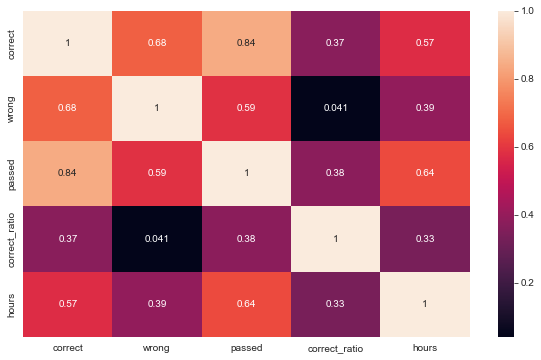

In [464]:
X_test = X_test.drop(columns=['steps_tried', 'discovered', 'viewed', 'started_attempt'])
correlation(X_test)

In [465]:
X_test.to_csv('data/X_valid.csv')
y_test.to_csv('data/y_valid.csv')

In [455]:
X, y = create_df(events_data, submissions_data)

In [456]:
X

,correct,wrong,discovered,passed,started_attempt,viewed,correct_ratio,steps_tried,hours
user_id,,,,,,,,,
2,2.0,0.0,9,9,2,9,1.0,2.0,0.1
3,4.0,4.0,15,15,4,20,0.5,4.0,0.3
5,2.0,2.0,1,1,0,1,0.5,2.0,0.0
8,9.0,21.0,109,84,37,154,0.3,11.0,0.2
14,0.0,1.0,4,3,1,9,0.0,1.0,0.7
...,...,...,...,...,...,...,...,...,...
26773,0.0,0.0,1,1,0,1,0.0,0.0,0.0
26774,0.0,0.0,1,1,0,1,0.0,0.0,0.0
26788,0.0,0.0,1,1,0,1,0.0,0.0,0.0


In [457]:
y

user_id
2        1
3        1
5        1
8        1
14       1
        ..
26773    1
26774    1
26788    1
26789    1
26793    1
Name: is_gone, Length: 19234, dtype: int32

In [463]:
def correlation(data):
    """Строим матрицу корреляций"""
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True)
    plt.show()


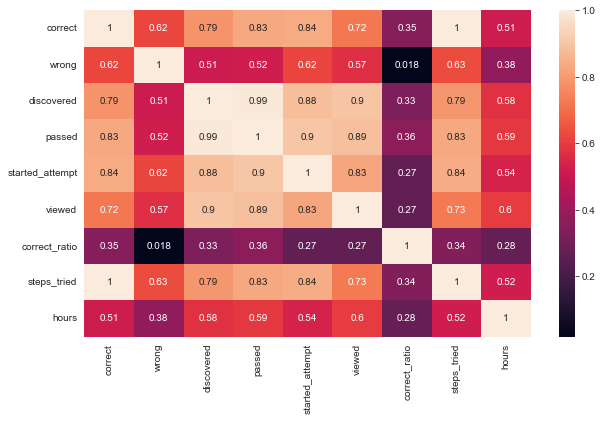

In [459]:
correlation(X)

In [460]:
# Удалим сильно коррелирующие признаки
X = X.drop(columns=['steps_tried', 'discovered', 'viewed', 'started_attempt'])
correlation(X)

KeyError: "['days'] not found in axis"

In [ ]:
y

In [ ]:
X.to_csv('data/X_new.csv')
y.to_csv('data/y_new.csv')